#Business Issue Understanding

Stres merupakan kondisi dimana seorang individu mengalami sebuah tekanan akibat dari ketidaksesuaian harapan dan keadaan yang sebenarnya. Stres dapat dipicu oleh berbagai faktor seperti pendidikan, pekerjaan, maupun ekonomi. Stres dapat menimbulkan berbagai gangguan kesehatan yang dapat menjadi semakin parah seiring dengan berjalannya waktu.


 Tingkat stress seseorang dapat diukur dengan berbagai macam teknik dan parameter. Ahmad, Mutiara, dan Rahma melakukan penelitian hubungan tingkat stres pada mahasiswa angkatan 2017 Fakultas Kedokteran Universitas Baiturrahman dengan kejadian insomnia yang dialami. Hasilnya didapatkan ada hubungan stres dengan kejadian insomnia yang dialami mahasiswa. Sementara itu Rachakonda dkk, melakukan penelitian tingkat stres menggunakan perangkat IoMT dengan mengambil beberapa parameter seperti tingkat mendengkur dari pengguna, pernapasan, temperatur tubuh, gerak tangan dan kaki, kadar oksigen dalam darah, pergerakan mata, lama waktu tidur, dan detak jantung pengguna. Selanjutnya data yang diperoleh diklasifikasikan dengan menggunakan algoritma jaringan saraf tiruan menjadi 5 kelas tingkat stres. Penelitian serupa juga dilakukan oleh Rahman dkk yang melakukan pengukuran tingkat stress seseorang menggunakan Electroencephalogram (EEG).


#Data Understanding

In [ ]:
!pip install opendatasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

In [ ]:
od.download('https://www.kaggle.com/datasets/laavanya/stress-level-detection?select=Stress-Lysis.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alifilazuardi
Your Kaggle Key: ··········


100%|██████████| 1.03M/1.03M [00:00<00:00, 51.5MB/s]

In [ ]:
df1 = pd.read_csv('/content/stress-level-detection/Stress-Lysis.csv')

#Data Preparation and Preprocessing

In [ ]:
# melihat deskripsi data

df1.describe()

,Humidity,Temperature,Step count,Stress Level
count,2001.000000,2001.000000,2001.000000,2001.000000
mean,20.000000,89.000000,100.141429,1.104448
std,5.777833,5.777833,58.182948,0.771094
min,10.000000,79.000000,0.000000,0.000000
25%,15.000000,84.000000,50.000000,0.000000
50%,20.000000,89.000000,101.000000,1.000000
75%,25.000000,94.000000,150.000000,2.000000
max,30.000000,99.000000,200.000000,2.000000


In [ ]:
# melakukan pengecekan missing value

df1.isnull().sum()

Humidity        0
Temperature     0
Step count      0
Stress Level    0
dtype: int64

In [ ]:
# melakukan pengecekan data duplikat

df1.duplicated().sum()

0

In [ ]:
# melakukan deteksi outlier dengan menggunakan iqr

def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [ ]:
for column in df1.columns:
  outliers = find_outliers_IQR(df1[column])
  print('number of outliers '+ column+ ' = '+ str(len(outliers)))

number of outliers Humidity = 0
number of outliers Temperature = 0
number of outliers Step count = 0
number of outliers Stress Level = 0


Tidak ada outlier

In [ ]:
# Merubah suhu menjadi celsius

df1['Temperature'] = (df1['Temperature']-32)*5/9

<Axes: >

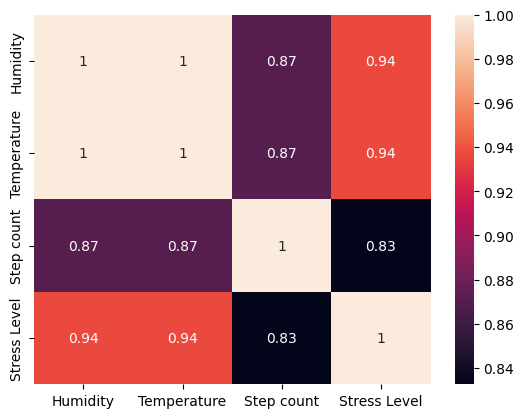

In [ ]:
# melihat korelasi data

sns.heatmap(df1.corr(), annot=True)

Setiap fitur mempunyai korelasi yang kuat terhadap stress level. Karena itu, fitur yang digunaka adalah seluruh fitur dalam dataset.

<Axes: xlabel='Stress Level', ylabel='count'>

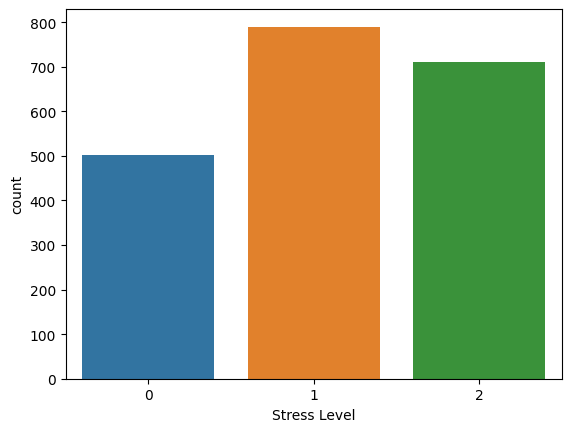

In [ ]:
# melihat perseberan kelas terget

sns.countplot(data = df1, x = "Stress Level")

setiap kelas mempunyai jumlah data yang hampir sama, tidak perlu dilakukan resample data.

#Exploratory Analysis and Modelling

In [ ]:
df1['Stess level categorical'] = df1['Stress Level']
df1['Stess level categorical'].replace(to_replace=[0, 1, 2], value=['low', 'normal', 'high'], inplace=True)
df1.head()

,Humidity,Temperature,Step count,Stress Level,Stess level categorical
0,21.33,32.405556,123,1,normal
1,21.41,32.450000,93,1,normal
2,27.12,35.622222,196,2,high
3,27.64,35.911111,177,2,high
4,10.87,26.594444,87,0,low


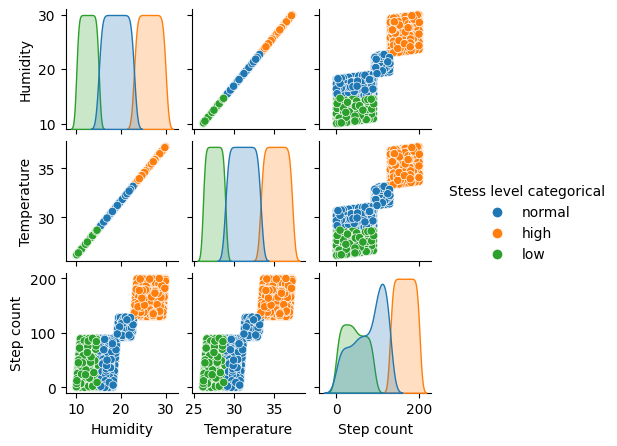

In [ ]:
# sns.set(font_scale=1.2)
sns.pairplot(data=df1[['Humidity', 'Temperature', 'Step count', 'Stess level categorical']], hue='Stess level categorical', height=1.5)

Visualisasi dilakukan dengan pairplot digunakan untuk menganalisis dua variabel data dan dikelompokkan berdasarkan kelas sesuai dengan warna. Pada plot bagian temperature dan humidity, terlihat adanya relasi dimana ketika temperature dan humidity semakin naik, level dari stress juga semakin bertambah. Artinya ketika temperatur tinggi dan humidity juga tinggi maka tingkat stress juga tinggi. 
Sementar itu pada plot bagian step count dan humidity, stress level cenderung lebih dipengaruhi oleh humidity. Terlihat ketika step count rendah, terdapat 2 kelas dari stress level yakni low dan normal. Tingkat stress pada step count rendah ini dipengaruhi oleh humidity. Unuk humidity rendah maka tingkat stres juga redah, sedangkan ketika humidity sedang maka tingkat stress berada pada level normal.
Hal serupa terjadi pada plot step count dan temperatur yang. Ketika temperature rendah, stress level dipengaruhi oleh humidity, semakin tinggi humidity semakin naik level stress nya.


Text(0, 0.5, 'Stress Level')

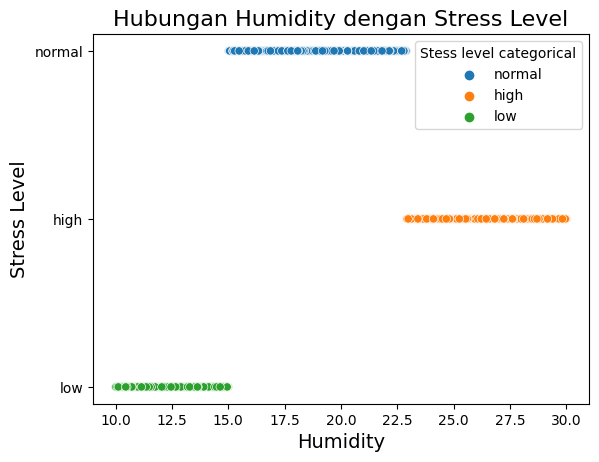

In [ ]:
humidity_plot = sns.scatterplot(data=df1, x='Humidity', y='Stess level categorical', hue='Stess level categorical')
humidity_plot.axes.set_title("Hubungan Humidity dengan Stress Level", fontsize=16)
humidity_plot.set_xlabel("Humidity", fontsize=14)
humidity_plot.set_ylabel("Stress Level", fontsize=14)

In [ ]:
import matplotlib 
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.7.1


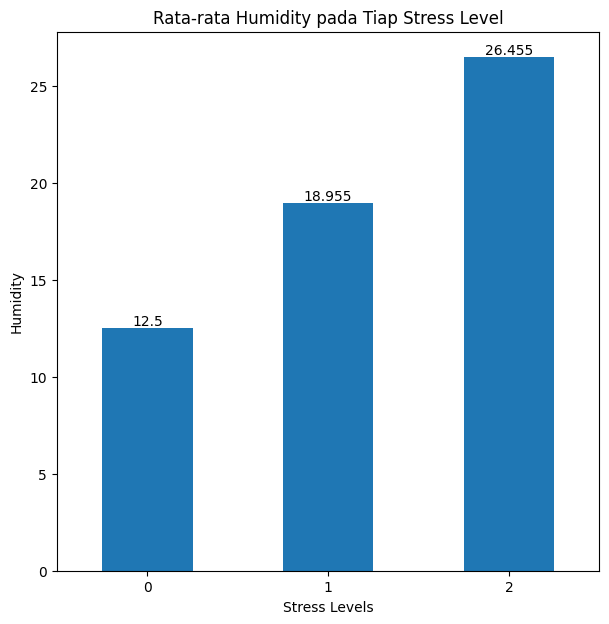

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
df1.groupby(df1["Stress Level"])["Humidity"].mean().plot(kind='bar', rot=0)
plt.title("Rata-rata Humidity pada Tiap Stress Level")
plt.xlabel("Stress Levels")
plt.ylabel("Humidity")
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()


Berdasarkan plot di atas, humidity mempunyai hubungan terhadap level stress. Ketika humidity dibawah 15, maka stress level adalah low, ketika berada di antara 15 dan 22 stress level berada pada level normal, sedangkan ketika lebih dari 22 maka stress level tinggi. Hal ini juga didukung plot di bawah yakni rata-rata humidity untuk setiap level stres.


Text(0, 0.5, 'Stress Level')

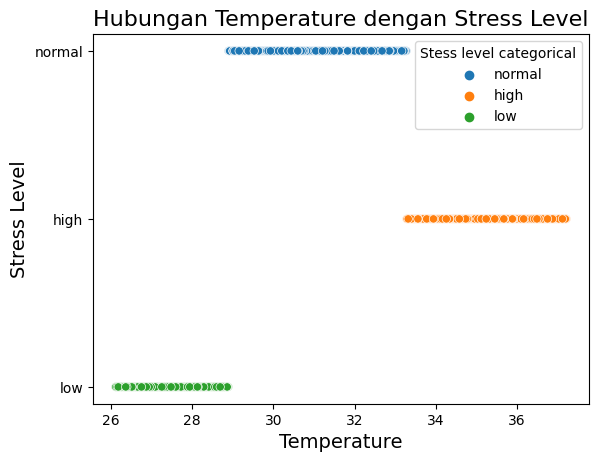

In [ ]:
temperature_plot = sns.scatterplot(data=df1, x='Temperature', y='Stess level categorical', hue='Stess level categorical')
temperature_plot.axes.set_title("Hubungan Temperature dengan Stress Level", fontsize=16)
temperature_plot.set_xlabel("Temperature", fontsize=14)
temperature_plot.set_ylabel("Stress Level", fontsize=14)

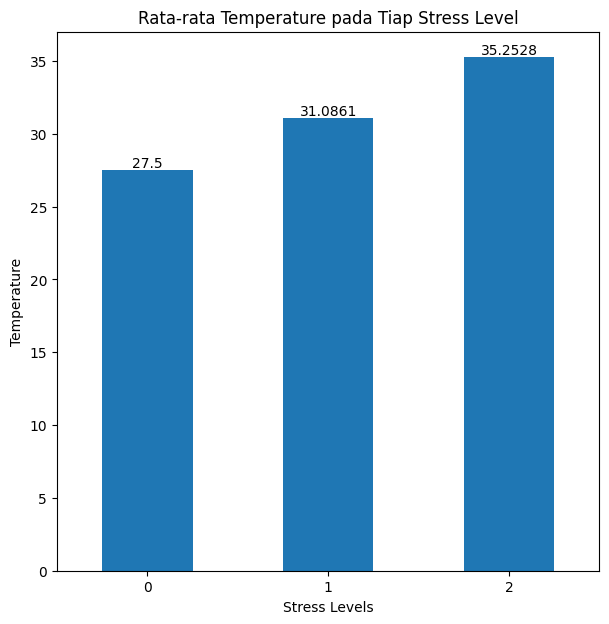

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
df1.groupby(df1["Stress Level"])["Temperature"].mean().plot(kind='bar', rot=0)
plt.title("Rata-rata Temperature pada Tiap Stress Level")
plt.xlabel("Stress Levels")
plt.ylabel("Temperature")
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

Sama seperti humidity, stress level dan temperatur juga mempunyai hubungan. Semakin tinggi temperatur  tubuh, maka tingkat stress juga semakin tinggi. Ketika temperatur berada di antara 26 dan 29 tingkat stress rendah. Ketika berada di antara 29-33 maka tingkat stress adalah sedang. Ketika temperatur tubuh lebih dari 33 maka tingkat stress tinggi. Berikut adalah plot rata-rata temperatur tubuh pada setiap tingkat stress.

Text(0, 0.5, 'Stress Level')

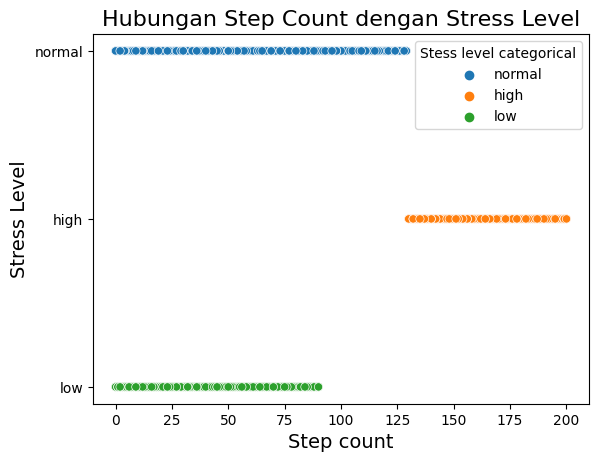

In [ ]:
sc_plot = sns.scatterplot(data=df1, x='Step count', y='Stess level categorical', hue='Stess level categorical')
sc_plot.axes.set_title("Hubungan Step Count dengan Stress Level", fontsize=16)
sc_plot.set_xlabel("Step count", fontsize=14)
sc_plot.set_ylabel("Stress Level", fontsize=14)

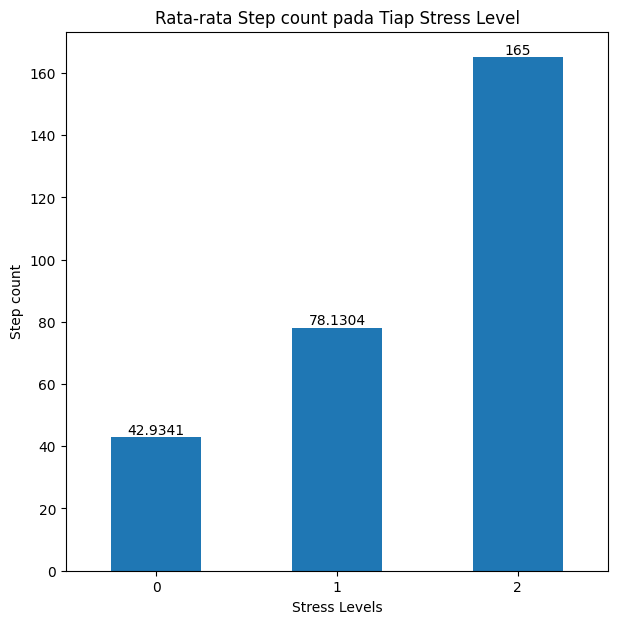

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
df1.groupby(df1["Stress Level"])["Step count"].mean().plot(kind='bar', rot=0)
plt.title("Rata-rata Step count pada Tiap Stress Level")
plt.xlabel("Stress Levels")
plt.ylabel("Step count")
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

Berbeda dengan kedua variabel di atas terjadi sedikit perbedaan relasi antara step count dengan stress level. Pada jumlah step count kurang dari 90 terdapat dua kelas stress level yakni low dan normal. Arting terdapat variabel lain yang mempengaruhi stress level pada step count dibawah 90. Namun ketika step count lebih dari 90, maka stress level berada pada level high. Dalam plot rata-rata step count pada tiap level stress, rata-rata pada level low dan normal tidak terpaut cukup jauh. Sedangkan pada level high terdapat perbedaan yang cukup signifikan.


In [ ]:
X = df1[['Temperature', 'Humidity', 'Step count']]
y = df1['Stess level categorical']

In [ ]:
sc = MinMaxScaler()
X = sc.fit_transform(X)

In [ ]:
X = pd.DataFrame(X,columns=['Temperature', 'Humidity', 'Step count'])

X

,Temperature,Humidity,Step count
0,0.5665,0.5665,0.615
1,0.5705,0.5705,0.465
2,0.8560,0.8560,0.980
3,0.8820,0.8820,0.885
4,0.0435,0.0435,0.435
...,...,...,...
1996,0.5910,0.5910,0.480
1997,0.0225,0.0225,0.225
1998,0.8610,0.8610,0.675
1999,0.1230,0.1230,0.320


In [ ]:
data_preprocesed = pd.DataFrame(X)
data_preprocesed['Stress Level'] = y

data_preprocesed

,Temperature,Humidity,Step count,Stress Level
0,0.5665,0.5665,0.615,normal
1,0.5705,0.5705,0.465,normal
2,0.8560,0.8560,0.980,high
3,0.8820,0.8820,0.885,high
4,0.0435,0.0435,0.435,low
...,...,...,...,...
1996,0.5910,0.5910,0.480,normal
1997,0.0225,0.0225,0.225,low
1998,0.8610,0.8610,0.675,high
1999,0.1230,0.1230,0.320,low


In [ ]:
data_preprocesed.to_csv('data_preprocesed.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

model K NN

In [ ]:
# #parameter yang akan diuji dalam grid search cv 

# parameters = [{'n_neighbors': [3, 5, 7, 11, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]

In [ ]:
# knn = GridSearchCV(KNeighborsClassifier(), parameters, scoring='accuracy', cv=10, verbose=3)
# knn.fit(X_train, y_train)

In [ ]:
# # mendapatkan paramter terbaik

# print(knn.best_params_)

In [ ]:
#Melatih model dengan paramter yang telah diperoleh

knn_classifier = KNeighborsClassifier(algorithm =  'auto', n_neighbors = 3, weights =  'uniform')
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
#prediksi dengan data test

knn_predict = knn_classifier.predict(X_test)
confusion_matrix(y_test, knn_predict)

array([[214,   0,   0],
       [  0, 140,   0],
       [  0,   1, 246]])

In [ ]:
print(classification_report(y_test, knn_predict)) 

              precision    recall  f1-score   support

        high       1.00      1.00      1.00       214
         low       0.99      1.00      1.00       140
      normal       1.00      1.00      1.00       247

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



model decission tree

In [ ]:
# #parameter yang akan diuji dalam grid search cv 

# range = np.arange(1, 30)

# parameters = [{'criterion': ['entropy', 'gini'], 'max_depth': range, 'min_samples_leaf': range}]

In [ ]:
# decision_tree = GridSearchCV(DecisionTreeClassifier(), parameters, scoring='accuracy', cv=10, verbose=3)
# decision_tree.fit(X_train, y_train)

In [ ]:
# # mendapatkan paramter terbaik

# print(decision_tree.best_params_)

In [ ]:
#Melatih model dengan paramter yang telah diperoleh

decision_tree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 2, min_samples_leaf= 1)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [ ]:
#prediksi dengan data test

dt_predict = decision_tree.predict(X_test)
confusion_matrix(y_test, dt_predict)

array([[214,   0,   0],
       [  0, 140,   0],
       [  2,   1, 244]])

In [ ]:
print(classification_report(y_test, dt_predict)) 

              precision    recall  f1-score   support

        high       0.99      1.00      1.00       214
         low       0.99      1.00      1.00       140
      normal       1.00      0.99      0.99       247

    accuracy                           1.00       601
   macro avg       0.99      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



#Validation

In [ ]:
knn_accuracy = accuracy_score(y_test, knn_predict)
dt_accuracy = accuracy_score(y_test, dt_predict)

In [ ]:
print('Akurasi model KNN adalah = ', knn_accuracy)
print('Akurasi model Decison Tree adalah = ', dt_accuracy)

Akurasi model KNN adalah =  0.9983361064891847
Akurasi model Decison Tree adalah =  0.9950083194675541


In [ ]:
a = ['KNN', 'Decision Tree']
b = [knn_accuracy, dt_accuracy]

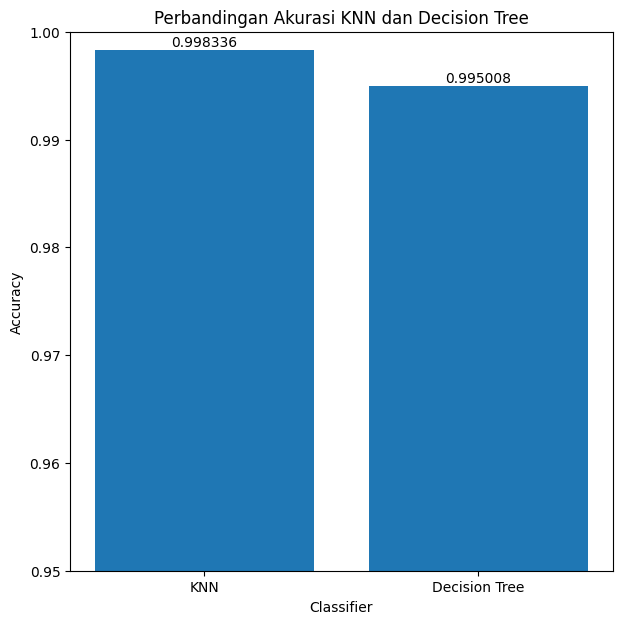

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
plt.bar(a, b)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Perbandingan Akurasi KNN dan Decision Tree')
for bars in ax.containers:
    ax.bar_label(bars)
ax.set_ylim(0.95, 1)
plt.show()

Berdasarkan perbandingan akurasi kedua model diperoleh kedua model mempunyai akurasi yang sama. Hal ini berarti kedua model mampu melakukan generalisasi yang baik terhadap permasalahan. Baik model KNN maupun decision tree menghasilkan akurasi 99.8%. Akurasi ini sudah termasuk sangat tinggi.

In [ ]:
knn_precision, knn_recall, knn_fscore, knn_support = score(y_test, knn_predict)
dt_precision, dt_recall, dt_fscore, dt_support = score(y_test, dt_predict)

In [ ]:
def count_total(var):
  sum = 0
  for a in var:
    sum += a
  return sum/3

In [ ]:
knn_precision_total = count_total(knn_precision)
knn_recall_total = count_total(knn_recall)
knn_fscore_total = count_total(knn_fscore)

In [ ]:
print('Presisi model KNN adalah = ', knn_precision_total)
print('Recall model KNN adalah = ', knn_recall_total)
print('F1 Score model KNN adalah = ', knn_fscore_total)

Presisi model KNN adalah =  0.9976359338061466
Recall model KNN adalah =  0.9986504723346828
F1 Score model KNN adalah =  0.9981376278576223


Berikut adalah presisi, recall, dan F1 score dari model KNN. Ketiga nilai evaluasi ini telah mencapai angka lebih dari 99%. Hal ini berarti model bekerja dengan baik. 

In [ ]:
dt_precision_total = count_total(dt_precision)
dt_recall_total = count_total(dt_recall)
dt_fscore_total = count_total(dt_fscore)

In [ ]:
print('Presisi model Decision Tree adalah = ', dt_precision_total)
print('Recall model Decision Tree adalah = ', dt_recall_total)
print('F1 Score model Decision Tree adalah = ', dt_fscore_total)

Presisi model Decision Tree adalah =  0.9945495140530601
Recall model Decision Tree adalah =  0.9959514170040485
F1 Score model Decision Tree adalah =  0.995226712904897


Berikut adalah presisi, recall, dan F1 score dari model Decision Tree. Ketiga nilai evaluasi ini telah mencapai angka lebih dari 99%. Hal ini berarti model bekerja dengan baik. 

In [ ]:
x = ['precision', 'recall', 'f score']
y = [knn_precision_total, knn_recall_total, knn_fscore_total]
z = [dt_precision_total, dt_recall_total, dt_fscore_total]

In [ ]:
y

[0.9976359338061466, 0.9986504723346828, 0.9981376278576223]

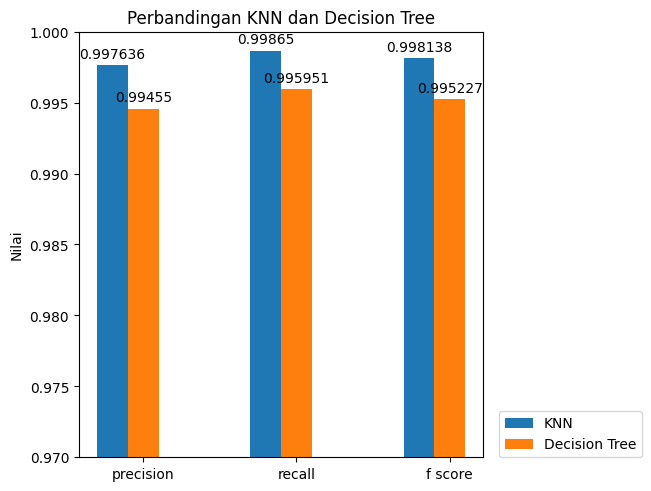

In [ ]:
measure = ('precision', 'recall', 'f score')
value = {
    'KNN': (knn_precision_total, knn_recall_total, knn_fscore_total),
    'Decision Tree': (dt_precision_total, dt_recall_total, dt_fscore_total)
}

x = np.arange(len(measure))  
width = 0.2  
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Nilai')
ax.set_title('Perbandingan KNN dan Decision Tree')
ax.set_xticks(x + width, measure)
ax.legend(loc=(1.04, 0))
ax.set_ylim(0.97, 1)

plt.show()

Berdasarkan plot di atas dapat diketahui bahwa model KNN mempunyai precision, dan f Score yang lebih baik dibandingkan dengan model Decision Tree. Sedangkan model Decision Tree unggul dalam recall. Precision merupakan rasio prediksi benar positif dibandingkan dengan keseluruhan hasil yang diprediksi positif. Recall merupakan rasio prediksi benar positif dibandingkan dengan keseluruhan data yang benar positif. F1 Score merupakan perbandingan rata-rata presisi dan recall yang dibobotkan. Dengan demikian KNN mempunyai F1 Score yang sedikit lebih baik dari pada Decision Tree. Berarti model KNN mampu melakukan klasifikasi yang lebih baik daripada model Decision Tree.

#Evaluation

**Apakah Suhu Tubuh, Kelembapan, Dan Langkah Kaki Dapat Mempengaruhi Tingkat Stress Seseorang? Cek Fakta Menurut Data**

Stres merupakan kondisi dimana seorang individu mengalami sebuah tekanan akibat dari ketidaksesuaian harapan dan keadaan yang sebenarnya. Banyak faktor yang dapat memengaruhi tingkat stress seseorang seperti pendidikan, pekerjaan, maupun ekonomi.



Lalu apakan faktor lain dapat mempengaruhi tingkat stress seseorang? Apakah suhu tubuh dapat mempengaruhi tingkat stress seseorang? Bagaimana dengan kelembapan tubuh seseorang? Lalu bagaimana dengan kebiasaan kita melangkah, apakah dapat mempengaruhi tingkat stress juga? 


Maka dari itu kami melakukan Exploratory Data Analysis (EDA) dari dataset yang kami temukan di kaggle tentang Human Stress Detection 
https://www.kaggle.com/datasets/laavanya/stress-level-detection?select=Stress-Lysis.csv


Lebih Banyak Orang Stress Dibanding Yang Tidak

Dengan melakukan eksplorasi data tersebut dapat kita lihat, dari 2001 sampel yang diambil dominan memiliki tingkat stres menengah dan dilanjutkan dengan tingkat stress yang tinggi yang membuat sampel yang memiliki tingkat stress rendah adalah yang paling sedikit. Dapat disimpulkan bahwa sampel yang diambil lebih dominan stress dibanding yang tidak.


Ternyata Suhu Tubuh Dapat Mempengaruhi Tingkat Stress Seseorang


Dapat kita lihat pada data tersebut, bahwa semakin tinggi suhu seseorang dapat menyebabkan semakin tinggi tingkat stress seseorang. Bahkan jika suhu tubuh sudah mencapai 33℃ dan diatasnya, dapat diyakini memiliki tingkat stress yang tinggi.

Kelembapan Pun Juga Dapat Memengaruhi

Ternyata hal yang berlaku untuk suhu tubuh, berlaku juga untuk kelembapan. Semakin tinggi tingkat kelembapan seseorang, maka semakin tinggi juga tingkat stress orang tersebut. Dapat dilihat jika kelembapan orang tersebut sudah diatas 22,5 maka tingkat stress orang tersebut sudah tinggi.

Langkah Kaki Yang Memiliki Kriteria Sedikit Unik

Sedikit unik disini karena adanya perbedaan dengan kedua faktor sebelumnya, yang dapat dilihat bahwa dengan langkah dibawah 90 terdapat dua tingkat stress yaitu normal dan high. Yang membuat bahwa langkah kaki dibawah 90 masih harus dibantu dengan variabel lain untuk mempengaruhi tingkat stress seseorang.

Korelasi Ketiga Faktor Tersebut Dengan Tingkat Stress

Ketiga faktor tersebut mempengaruhi tingkat stress seseorang, terutama faktor suhu tubuh dan juga kelembapan, meskipun langkah kaki tidak seperti dua faktor lainnya tetapi tetap berpengaruh besar terhadap tingkat stress seseorang.

Ternyata dari hasil yang kita dapatkan bahwa benar adanya faktor suhu tubuh, kelembapan, dan langkah kaki seseorang memiliki pengaruh terhadap tingkat stress orang tersebut. Sehingga kedepannya kita dapat lebih waspada dengan keadaan tubuh kita agar tidak stress juga ya.
